# Objectifs

Ce carnet vise à mettre en oeuvre certains des algorithmes de base du traitement d'image.
<br>Nous nous concentrons ici sur l'ajout de **flou** dans une image.
<br>
<br>Dans la suite de ce carnet, nous :
* Mettons en oeuvre les librairies Python déjà à disposition.
* Implémentons un algorithme de flou basique.
* Évaluons l'importance du décomposition de noyau sur la performance ("separable filters).

# Préliminaires

Commandes utiles pour l'ensemble des parties qui suivent et qui pourront être appelées à plusieurs reprises :
* Chargement des librairies.
* Chargement des données de test.

In [119]:
# Chargement des librairies
import numpy as np
import matplotlib.pyplot as plt
import ipyplot
from scipy import linalg,ndimage
from PIL import Image,ImageFilter,ImageEnhance
from skimage.draw import disk, polygon
from time import time

In [120]:
# Configuration basique
%matplotlib inline
plt.style.use('seaborn-whitegrid')

# Librairie Pillow

La librairie **Pillow** propose les filtres les plus classiques.
<br>Plus d'informations <a href="https://pillow.readthedocs.io/en/5.1.x/index.html">ici</a>.

In [138]:
# Lien vers les images
mario_small_filepath = "./images/supermario_small.jpg"
mario_medium_filepath = "./images/supermario_medium.jpg"
mario_large_filepath = "./images/supermario_large.jpg"

In [139]:
# Chargement des images
mario_small_img = Image.open(mario_small_filepath)
mario_medium_img = Image.open(mario_medium_filepath)
mario_large_img = Image.open(mario_large_filepath)

In [140]:
# Caractéristiques et visualisation des images
small_size = mario_small_img.size
medium_size = mario_medium_img.size
large_size = mario_large_img.size

Ci-dessous, nous visualisons l'effet des filtres de bases :

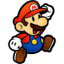

size: (64, 64)


In [47]:
# Visualisation de l'image originale
display(mario_small_img)
print("size:",mario_small_img.size)


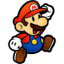
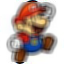
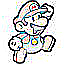
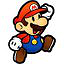
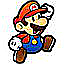
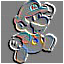
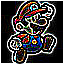
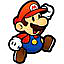
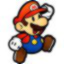


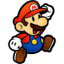
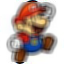
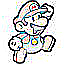
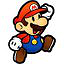
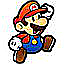
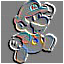
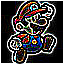
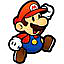
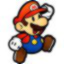

In [124]:
# Traitement et visualisation avec ImageFilter
pil_filtername = ['ORIGINAL','BLUR','CONTOUR','DETAIL','ENHANCE','EMBOSS',
               'EDGES','SHARPEN','SMOOTH']
pil_filters = [ImageFilter.BLUR,ImageFilter.CONTOUR,
               ImageFilter.DETAIL,ImageFilter.EDGE_ENHANCE,ImageFilter.EMBOSS,
               ImageFilter.FIND_EDGES,ImageFilter.SHARPEN,ImageFilter.SMOOTH]

pil_filtered_marios = [mario_small_img]

for pil_filter in pil_filters:
    tmp_img = mario_small_img.filter(pil_filter)
    pil_filtered_marios.append(tmp_img)
    
ipyplot.plot_images(images=pil_filtered_marios,
                    img_width=small_size[1],
                    labels=pil_filtername)

# Libraire Scipy

La librairie Scipy propose aussi certains des filtres les plus classiques, notamment grâce au module **ndimage**.
<br>Elle permet aussi de calculer la convolution d'une image avec un noyau de taille arbitraire (contrairement à Pillow.Kernel() qui limite la taille du kernel à 3x3 ou 5x5).
<br>Plus d'informations <a href="https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html">ici</a>.

**Remarque**
<br>\- Pour les filtres de détection de contour, il faut partir d'une image en niveau de gris.
<br>\- La conversion en niveau de gris doit tenir compte de la sensibilité de l'oeil qui est différente pour chaque couleur : $I \sim 0.2126 R + 0.7152 G + 0.0722$ (cf. <a href="https://e2eml.school/convert_rgb_to_grayscale.html">e2eML school</a>).
<br>\- La librairie ipyplot ne support que des images PIL avec 3 canaux (en 'RGB') donc.


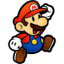
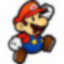
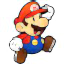
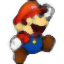
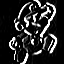
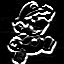
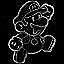


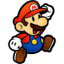
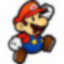
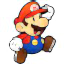
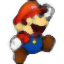
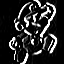
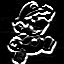
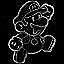

In [128]:
# Traitement et visualisation
mario_small_np = np.array(mario_small_img)
mario_small_shape = mario_small_np.shape
mario_small_grey_np = np.array(mario_small_img.convert('L'))

ndimg_filternames = ['ORIGINAL','GAUSS','MAXIMUM',
                     'MEDIAN','SOBEL-X','SOBEL-Y','LAPLACE']

mario_gauss_np = np.zeros(mario_small_shape,dtype=np.uint8)
for i in range(3):
    mario_gauss_np[:,:,i] = ndimage.gaussian_filter(
                            mario_small_np[:,:,i], sigma=1)

mario_max_np = np.zeros(mario_small_shape,dtype=np.uint8)
for i in range(3):
    mario_max_np[:,:,i] = ndimage.maximum_filter(
                            mario_small_np[:,:,i], size=2) 

mario_median_np = np.zeros(mario_small_shape,dtype=np.uint8)
for i in range(3):
    mario_median_np[:,:,i] = ndimage.median_filter(
                            mario_small_np[:,:,i], size=5)    

mario_sobelx_np = np.zeros(mario_small_grey_np.shape)
ndimage.sobel(mario_small_grey_np,axis=1,output=mario_sobelx_np)
mario_sobelx_np = np.clip(mario_sobelx_np,0,255)
mario_sobelx_np = np.array(
    Image.fromarray(mario_sobelx_np).convert('RGB'))

mario_sobely_np = np.zeros(mario_small_grey_np.shape)
ndimage.sobel(mario_small_grey_np,axis=0,output=mario_sobely_np)
mario_sobely_np = np.clip(mario_sobely_np,0,255)
mario_sobely_np = np.array(
    Image.fromarray(mario_sobely_np).convert('RGB'))

mario_laplace_np = np.zeros(mario_small_grey_np.shape)
ndimage.laplace(mario_small_grey_np,output=mario_laplace_np)
mario_laplace_np = np.clip(mario_laplace_np,0,255)
mario_laplace_np = np.array(
    Image.fromarray(mario_laplace_np).convert('RGB'))

ndimg_filtered_marios = [mario_small_np,mario_gauss_np,
                         mario_max_np,mario_median_np,
                         mario_sobelx_np,mario_sobely_np,
                         mario_laplace_np]

ipyplot.plot_images(images=ndimg_filtered_marios,
                    img_width=small_size[1],
                    labels=ndimg_filternames)

# Filtre gaussien

## Implémentation du noyau Gaussien

Deux méthodes sont possibles :
* Passer par la **fonction gaussienne**
  <br>Permet de gérer la valeur de sigma mais nécessite de manipuler des valeurs non entières...
  <br>Plus d'informations sur l'approche : <a href="https://www.adeveloperdiary.com/data-science/computer-vision/applying-gaussian-smoothing-to-an-image-using-python-from-scratch/">ici</a>.
  <br>
  <br>
* Passer par le **triangle de Pascal**
  <br>Permet de récupérer une distribution classique en valeur entière mais sans aucune paramétrisation possible...
  <br>Plus d'informations sur l'approche : <a href="https://computergraphics.stackexchange.com/questions/39/how-is-gaussian-blur-implemented">ici</a>.

**Méthode 1 : Fonction gaussienne**
Nous nous appuyons sur la fonction :
<br><center> ${\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\,\pi }}}}\,\mathrm {e} ^{-{\frac {\left(x-\mu \right)^{2}}{2\sigma ^{2}}}}}$ </center>

In [130]:
# dnorm(), compute the density using the formula of Univariate Normal Distribution
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

In [131]:
# algebra_gaussian_kernel(), compute gaussian kernel 1D or 2D based on gaussian function
def algebra_gaussian_kernel(size, dim=1, sigma=-1, verbose=False):

    # set sigma value automatically (optional)
    if sigma<0:
        # sigma = sqrt(n)/2
        sigma = np.sqrt(size)/2

    # compute 1D distribution
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
        
    # compute 2D distribution using outer product (Rij = Ai*Bj)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)  
 
    # show results (optional)
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Gaussian Kernel ( %.0f X %.0f )" %(size,size))
        plt.grid(False)
        plt.show()
    
    # return normal distribution based on dimension
    if dim==1:
        kernel = kernel_1D
    elif dim==2:
        kernel = kernel_2D
    else:
        raise ValueError('Dimension must be either 1 or 2. Current value : %s' %(dim))
 
    return kernel

**Méthode 2 : Triangle de Pascal**
<br>Pour rappel la loi binomiale :
<center>${P} (X=k)={n \choose k}\,p^{k}(1-p)^{n-k}$</center>
<br>est très bien approchée par la loi normale ${\mathcal {N}}(\mu ,\sigma ^{2})$ avec $\mu = np$ et $\sigma ^{2} = np(1-p)$.
<br>
<br>
<br>Pour une loi symétrique ($p= 1/2$), il vient : ${P} (X)=\frac{1}{{2}^{n}}\,{n \choose k} \sim {\mathcal {N}}(\mu = \frac{n}{2},\sigma^{2}=\frac{n}{4})$
<br>
<br>Nous voyons donc que la normale est directement liée aux coefficients binomiaux de rang n.

In [149]:
# pascal_gaussian_kernel(), compute gaussian kernel 1D or 2D based on pascal triangle
def pascal_gaussian_kernel(size, dim=1, verbose=False):

    # compute 1D distribution based on scipy library
    # fetch binomial coefficients from Pascal Triangle then normalize
    kernel_1D = linalg.pascal(size)[::-1].diagonal().astype(np.float)
    kernel_1D = kernel_1D / np.sum(kernel_1D)
        
    # compute 2D distribution using outer product (Rij = Ai*Bj)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T) 
 
    # show results (optional)
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Gaussian Kernel ( %.0f X %.0f )" %(size,size))
        plt.grid(False)
        plt.show()
    
    # return normal distribution based on dimension
    if dim==1:
        kernel = kernel_1D
    elif dim==2:
        kernel = kernel_2D
    else:
        raise ValueError('Dimension must be either 1 or 2. Current value : %s' %(dim))
 
    return kernel

**Remarque**
<br>Les deux approches doivent être équivalentes en termes de résultats. Nous le vérifions ci-dessous.
<br>Il suffit d'adapter la valeur prise par l'écart-type dans le génération du noyau à partir de la fonction gaussienne :
<br>
<br>
<center>$\sigma^{2}=\frac{n}{4} \implies \sigma = \frac{\sqrt{n}}{2} $</center>
<br>
<br>Cette valeur de $\sigma$ est celle prise défaut dans la fonction gaussienne.

In [61]:
# Unit Test Specifiation
kernel_size = 5
kernel_dim = 1
kernel_verb = True

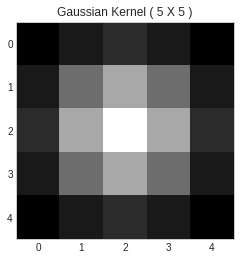

sum: 0.979281865788297
[0.07204169 0.23918683 0.35682482 0.23918683 0.07204169]
----


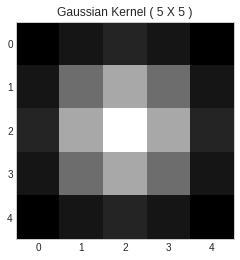

sum: 1.0
[0.0625 0.25   0.375  0.25   0.0625]
----


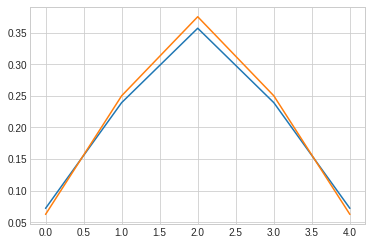

In [65]:
# Unit test
alg_k = algebra_gaussian_kernel(size=kernel_size, dim=kernel_dim,verbose=kernel_verb)
print('sum:',np.sum(alg_k))
print(alg_k)
print('----')
pas_k = pascal_gaussian_kernel(size=kernel_size, dim=kernel_dim,verbose=kernel_verb)
print('sum:',np.sum(pas_k))
print(pas_k)
print('----')
plt.plot(alg_k)
plt.plot(pas_k)
plt.show()

In [129]:
# Thumbnail specification
test_sizes = [3,11,33,99]

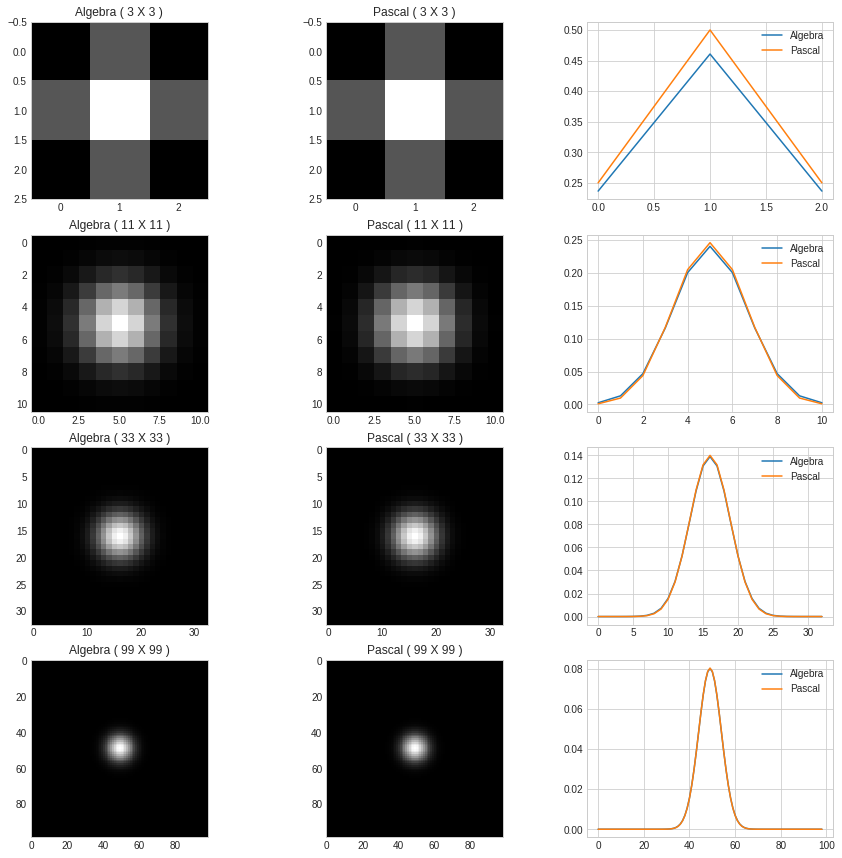

In [133]:
# Thumbnail generation
fig, axs = plt.subplots(figsize=(15.0,15.0),nrows=len(test_sizes),ncols=3)

for i in range(len(test_sizes)):
    axs[i,0].imshow(algebra_gaussian_kernel(size=test_sizes[i], dim=2),
                    interpolation='none',cmap='gray')
    axs[i,0].grid(None)
    axs[i,0].set_title("Algebra ( %.0f X %.0f )" %(test_sizes[i],test_sizes[i]))
    axs[i,1].imshow(pascal_gaussian_kernel(size=test_sizes[i], dim=2),
                    interpolation='none',cmap='gray')
    axs[i,1].grid(None)
    axs[i,1].set_title("Pascal ( %.0f X %.0f )" %(test_sizes[i],test_sizes[i]))
    axs[i,2].plot(algebra_gaussian_kernel(size=test_sizes[i], dim=1))
    axs[i,2].plot(pascal_gaussian_kernel(size=test_sizes[i], dim=1))
    axs[i,2].legend(['Algebra','Pascal'], loc='upper right')
    
plt.show()

## Implémentation de la convolution

Calcul de la convolution entre une image et un noyau de convolution ("kernel").
<br>
<br>**Illustration**
<br><img src="./schémas/convolution.gif" style="width: 200px"/>
<br>
**Formalisme**
<br>D'un point de vue mathématique, le formalisme est le suivant :
* Soit l'image $I \in \mathcal{M}_{m \times n}$
* Soit le noyau de convolution $F \in \mathcal{M}_{p \times q}$

Alors la convolution entre $I$ et $F$, s'écrit :
<br><center>$(I*F)[m,n] = \sum_{i=-p/2}^{p/2}\sum_{j=-q/2}^{q/2}F[i,j]\cdot I[m-i,n-j]$</center>
<br>
<br>**Source**
<br><a href="https://perso.esiee.fr/~perretb/I5FM/TAI/convolution/index.html">Cours sur le traitement et l'analyse d'images (ESIEE)</a>

In [142]:
# convolve_filter(), compute convolution of a PIL image and a kernel array
def convolve_filter(image,kernel,verbose=False):
    # Convert PIL image to array
    in_img = np.array(image)
    
    # Get basic properties
    img_height, img_width, channel_count = in_img.shape
    ker_height, ker_width = kernel.shape
    if verbose:
        print("Input image dimensions : (width=%0.f x height=%0.f)." %(img_width, img_height))
        print("Number fo channels in image : %.0f." %(channel_count))
        display(image)
        print("Kernel size : (width=%0.f x height=%0.f)." %(ker_width, ker_height))
        plt.imshow(kernel, interpolation='none',cmap='gray')
        plt.grid(False)
        plt.show()       
    
    # Check kernel format
    if not (ker_height % 2 and ker_width % 2):
        raise ValueError('Both kernel dimensions must be odd. Current value : (%.0f x %.0f).' 
                         %(kernel.shape[0],kernel.shape[1]))
   
    # Compute usable range
    crop_height = ker_height // 2
    crop_width = ker_width // 2
    out_height = img_height - 2*crop_height
    out_width = img_width - 2*crop_width
    
    # Compute convolution
    out_img = np.zeros([out_height,out_width,channel_count],dtype=np.float)
    for c in range(channel_count):
        for x in range(out_width):
            for y in range(out_height):
                xmin = x
                xmax = x+ker_width
                ymin = y
                ymax = y+ker_height
                
                window = in_img[ymin:ymax,xmin:xmax,c]

                out_img[y,x,c] = np.sum(np.multiply(window,kernel))
                
    output = Image.fromarray(out_img.astype('uint8'))
    if verbose:
        print("Ouput image dimensions : (width=%0.f x height=%0.f)." %(out_width, out_height))
        display(output)
        
    return output        

In [136]:
# Calculs pour l'exemple de Mario (grande image)
gauss_ker = pascal_gaussian_kernel(31, dim=2)
mario_medium_blurred_img = convolve_filter(mario_medium_img,gauss_ker,verbose=False)

**Exemple**
Application d'un noyau de convolution gaussien sur l'image de Super Mario grâce à une implémentation maison.


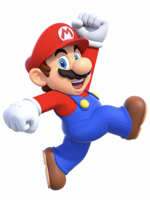
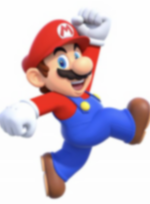


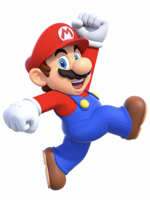
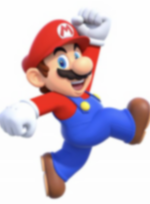

In [137]:
# Visualisation des résultats
ipyplot.plot_images(images=[mario_medium_img,mario_medium_blurred_img],
                    img_width=150,
                    labels=['ORIGINAL','BLURRED'])

## Comparaison avec un filtre séparable

**Principe général**
<br>Commençons par remarquer que certains noyau de convolution peuvent être décomposés.
<br>
<br>Exemple:
* Filtre de Sobel
<br>$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1\end{bmatrix} = \begin{bmatrix} 1 \\ 2 \\ 1\end{bmatrix} \begin{bmatrix} -1 & 0 & 1\end{bmatrix}$
<br>
<br>
* Filtre Gaussien
<br>$\frac {1}{16}\begin{bmatrix} 1 & 2 & 1 \\ 2 & 4 & 2 \\ 1 & 2 & 1\end{bmatrix} = {\frac {1}{4}}\begin{bmatrix} 1 \\ 2 \\ 1\end{bmatrix}*{\frac {1}{4}} \begin{bmatrix} -1 & 0 & 1\end{bmatrix}$
<br>
<br>
* Filtre Moyenneur
<br>$\frac {1}{9}\begin{bmatrix}1&1&1\\1&1&1\\1&1&1\end{bmatrix}=\frac {1}{3}\begin{bmatrix}1\\1\\1\end{bmatrix}*{\frac {1}{3}}\begin{bmatrix}1&1&1\end{bmatrix}$
<br>
<br>Par ailleurs, pour une image $I\in \mathcal{M}_{m \times n}$ et un noyau $F\in \mathcal{M}_{p \times q}$ pouvant se décomposer en $F = F_1 \times F_2$, nous avons :
<br>
<br><center>$I*F=(I*F_1)*F_2$</center>
où $F_1\in \mathcal{M}_{p \times 1}$ et $F_2\in \mathcal{M}_{1 \times q}$ 

**Démonstration**
<br>
Soit la convolution entre l'image $x[m,n]$ et le noyau $h[p,q]=f[p]\cdot g[q]$:
<br>
<br><center>$y[m,n] = (x\star h)[m,n]$</center>
<br>
$\begin{align}
y[m,n] &= \sum_i \sum_j h[i,j]  \cdot x[m-i,n-j] \\
&= \sum_i  \sum_j (f[i]\cdot g[j]) \cdot x[m-i,n-j] \\
&= \sum_i  f[i] \cdot \left( \sum_j g[j] \cdot x[m-i,n-j] \right) \\
\end{align}$
<br>
Soit $w[m-i,n]$ la convolution de $g[q]$ et $x[m-i,n]$ à $i$ fixé, ce qui revient par changement d'indice à :
<br>
<br><center>$w[k,r] = (x\star g)[k,r] = \sum_s g[s] \cdot x[k,r-s]$</center>
<br>
<br>
$\begin{align}
y[m,n] &= \sum_i  f[i] \cdot w[m-i,n] \\
&= (w \star f)[m,n] \\
&= ((x \star g) \star f)[m,n] \rightarrow CQFD \\
\end{align}$


**Source**
<br><a href="https://dsp.stackexchange.com/questions/52479/prove-that-convolution-with-a-separable-filter-is-equivalent-to-convolution-on-e">Démonstration sur le forum StackExchange</a>


**Intérêt de la méthode**
<br>Les performances en termes de temps de calcul sont nettement améliorées.
<br>
<br>La compléxité dépend :
* de la taille de l'image $O(mn)$.
* de la taille du noyau de convolution : $O(pq)$ qui devient $O(p+q)$ après décomposition.

In [150]:
def convolve_separable_filter(image,kernel_y,kernel_x,verbose=False):
    # Convert PIL image to array
    in_img = np.array(image)
    
    # Get basic properties
    img_height, img_width, channel_count = in_img.shape
    ker_height, = kernel_y.shape
    ker_width, = kernel_x.shape
    
    if verbose:
        print("Input image dimensions : (width=%0.f x height=%0.f)." %(img_width, img_height))
        print("Number fo channels in image : %.0f." %(channel_count))
        display(image)
        print("Kernel size : ker_width=%.0f, ker_height=%.0f)." %(ker_height,ker_width))
        kernel = np.matmul(kernel_y.reshape(-1,1),kernel_x.reshape(1,-1))
        plt.imshow(kernel, interpolation='none',cmap='gray')
        plt.grid(False)
        plt.show()       
    
    # Check kernel format
    if not (ker_height % 2 and ker_width % 2):
        raise ValueError('Both kernels must be odd length. \
                        Current value : (ker_y=%.0f, ker_x=%.0f).' 
                         %(ker_y_len,ker_x_len))
   
    # Compute usable range
    crop_height = ker_height // 2
    crop_width = ker_width // 2
    out_height = img_height - 2*crop_height
    out_width = img_width - 2*crop_width
    
    # Compute convolution with Y-kernel
    tmp_img = np.zeros([out_height,img_width,channel_count],dtype=np.float)
    for c in range(channel_count):
        for x in range(img_width):
            for y in range(out_height):                
                tmp_img[y,x,c] = np.dot(kernel_y,
                                        in_img[y:y+ker_height,x:x+1,c])
    
    # Compute convolution with X-kernel
    out_img = np.zeros([out_height,out_width,channel_count],dtype=np.float)
    for c in range(channel_count):
        for x in range(out_width):
            for y in range(out_height): 
                out_img[y,x,c] = np.dot(tmp_img[y:y+1,x:x+ker_width,c],
                                        kernel_x)
                
    output = Image.fromarray(out_img.astype('uint8'))
    if verbose:
        print("Ouput image dimensions : (width=%0.f x height=%0.f)." %(out_width, out_height))
        display(output)
        
    return output 

In [151]:
def diff_image(image1,image2,disp=False,out=True):
    crop_shape = np.minimum(np.array(image1).shape,np.array(image2).shape)

    img1_crop = np.array(image1)[:crop_shape[0],:crop_shape[1],:]
    img2_crop = np.array(image2)[:crop_shape[0],:crop_shape[1],:]

    diff_img = Image.fromarray((img1_crop - img2_crop).astype('uint8'))
    
    if disp:
        display(diff_img)
    
    if not out:
        diff_img = None
    
    return diff_img

**Exemple**
<br>Vérification de la différence de performance sur un cas simple.

In [141]:
# Données de test
test_img = mario_medium_img
kernel_test_size =  31

In [143]:
# Calcul pour le modèle classique (kernel 2D)
gauss_ker_2D = pascal_gaussian_kernel(kernel_test_size, dim=2)

start_time = time()

mario_large_classic_img = convolve_filter(
    test_img,gauss_ker_2D,verbose=False)

classic_exec_time = ("%.2f s" % (time() - start_time))

In [145]:
# Calcul pour la version séparable
gauss_ker_1D = pascal_gaussian_kernel(kernel_test_size, dim=1)

start_time = time()

mario_large_separable_img = convolve_separable_filter(
    test_img,gauss_ker_1D,gauss_ker_1D,verbose=False)

separable_exec_time = ("%.2f s" % (time() - start_time))


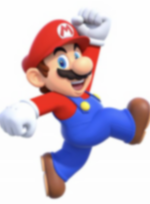
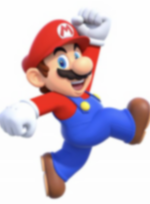


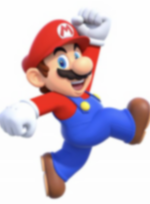
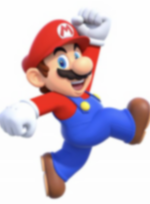

In [146]:
# Visualisation des résultats
ipyplot.plot_images(images=[mario_large_classic_img,mario_large_separable_img],
                    img_width=150,
                    labels=['CLASSIQUE','SÉPARABLE'],
                    custom_texts=[classic_exec_time,separable_exec_time])


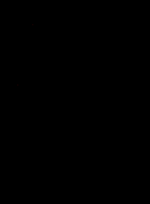


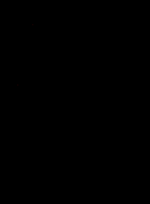

In [148]:
# Visualisation de la différence
diff_img = diff_image(mario_large_classic_img,mario_large_separable_img)
ipyplot.plot_images(images=[diff_img],img_width=150,labels=['Difference'])

Nous remarquons que la convolution sur le noyau décomposée et effectivement plus rapide (d'un facteur 3 ici), pour un résultat parfaitement identique.

## Parenthèse "Distorsion Chromatique"

**Remarque**
<br>Si nous observons la "différence" des résultats obtenus en passant la même image par deux filres tous les deux gaussiens mais avec une taille de noyau légèrement différente, nous voyons apparaître l'image initiale mais avec une sorte de "distorsion chromatique".
<br>Cet effet totalement inattendu est un bel exemple de *sérendipité*.
<br>
<br>Exemple ci-dessous:

In [152]:
def chromatic_distorsion(image,size1,size2,disp=False,out=True):
    gauss1_ker_1D = pascal_gaussian_kernel(size1, dim=1)
    gauss2_ker_1D = pascal_gaussian_kernel(size2, dim=1)
    conv1_img = convolve_separable_filter(image,gauss1_ker_1D,gauss1_ker_1D)
    conv2_img = convolve_separable_filter(image,gauss2_ker_1D,gauss2_ker_1D)

    chrom_img = diff_image(conv1_img,conv2_img,disp=disp,out=out)
        
    return chrom_img


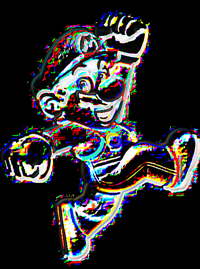


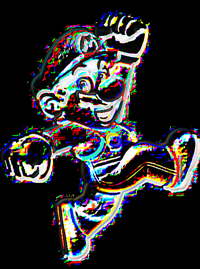

In [153]:
# Visualisation de la distorsion chromatique
# Couples de valeurs intéressants (3,5),(5,3),(5,31),(9,13),(41,1),(1,41)
chrom_img = chromatic_distorsion(mario_medium_img,9,13,disp=False,out=True)
ipyplot.plot_images(images=[chrom_img],labels=[''],img_width=200)